# Airbnb Price Prediction

## Business Understanding

Pricing on the online booking systems is a difficult task for the host, the systems usually set the prices that are lower than the general premises and quality, and that only gives benefits to the system by easily attracting the customer to use the service. The setting price of the new accommodation is often based on location, the number of beds, type of house and so on. The main problem is to predict the most reasonable price for the host. This work aims to study the use of machine learning and sentiment analysis for predicting the price of online booking systems.

This project aims to answer these questions:

1.   How is the price distributed in different areas?
2.   How do different models predict the house price?
3.   How to improve the prediction result?

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 16.7 MB 297 kB/s 
     |████████████████████████████████| 6.3 MB 36.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost
from sklearn import metrics
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
import copy
import geopandas as gp
from shapely.geometry import Point

## Data Understanding

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS-nanodegree/Project 1/data/listings_detail.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20190914144451,2019-09-15,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,NaN,NaN,https://a0.muscache.com/im/pictures/1d720898-c...,NaN,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/2beb9...,https://a0.muscache.com/im/pictures/user/2beb9...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Brixton,Lambeth,...,$20.00,2,180,2,2,180,180,2.0,180.0,4 days ago,t,19,42,72,344,2019-09-15,184,1,2010-03-21,2019-07-10,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.59
1,13913,https://www.airbnb.com/rooms/13913,20190914144451,2019-09-15,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Islington, Greater London, United Kingdom",LB of Islington,Islington,...,$15.00,1,29,1,1,29,29,1.0,29.0,5 months ago,t,18,48,78,353,2019-09-15,16,2,2010-08-18,2019-06-10,96.0,9.0,10.0,9.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,3,1,2,0,0.14
2,15400,https://www.airbnb.com/rooms/15400,20190914144451,2019-09-15,Bright Chelsea Apartment. Chelsea!,Lots of windows and light

In [ ]:
df.shape

(85273, 106)

In [ ]:
df.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.527300e+04,8.527300e+04,0.0,0.0,0.0,8.527300e+04,0.0,85257.000000,85257.000000,0.0,85273.000000,85273.000000,85273.000000,85146.000000,85231.000000,85120.000000,414.000000,85273.000000,85273.000000,8.527300e+04,85273.000000,85273.000000,8.527300e+04,8.527300e+04,85273.000000,8.527300e+04,85273.000000,85273.000000,85273.000000,85273.000000,85273.000000,85273.000000,62591.000000,62540.000000,62553.000000,62492.000000,62547.000000,62493.000000,62492.000000,85273.000000,85273.000000,85273.000000,85273.000000,64270.000000
mean,2.247762e+07,2.019091e+13,NaN,NaN,NaN,8.274633e+07,NaN,30.899023,30.899023,NaN,51.509717,-0.127944,3.203394,1.305651,1.417454,1.755886,656.526570,1.615119,4.120378,2.012749e+04,4.043789,7.282739,2.011345e+04,4.530640e+04,5.188853,4.518756e+04,7.662519,19.013099,31.816566,118.748220,16.817187,6.613442,92.514403,9.500304,9.261474,9.624032,9.648280,9.526907,9.265410,24.932171,22.173830,1.915941,0.046474,1.178735
std,1.090901e+07,3.964867e+01,NaN,NaN,NaN,8.308676e+07,NaN,166.229129,166.229129,NaN,0.046284,0.092379,2.024779,0.614770,0.922702,1.278712,894.709986,1.355782,15.652774,3.883024e+06,15.662134,22.449014,3.883025e+06,8.316147e+06,16.741713,8.286262e+06,10.075895,21.719618,34.179486,134.722596,35.673929,12.701369,10.257629,0.999424,1.149807,0.906819,0.905678,0.830359,1.047892,131.092708,130.392614,7.988816,0.687947,1.375759
min,1.155100e+04,2.019091e+13,NaN,NaN,NaN,2.697000e+03,NaN,0.000000,0.000000,NaN,51.294790,-0.509160,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.408781e+07,2.019091e+13,NaN,NaN,NaN,1.497083e+07,NaN,1.000000,1.000000,NaN,51.485510,-0.187990,2.000000,1.000000,1.000000,1.000000,129.000000,1.000000,1.000000,3.100000e+01,1.000000,1.000000,3.000000e+01,3.100000e+01,1.000000,3.100000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.240000
50%,2.299883e+07,2.019091e+13,NaN,NaN,NaN,4.676536e+07,NaN,2.000000,2.000000,NaN,51.514030,-0.125920,2.000000,1.000000,1.000000,1.000000,517.000000,1.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,2.000000,9.000000,16.000000,61.000000,4.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.740000
75%,3.233502e+07,2.019091e+13,NaN,NaN,NaN,1.379850e+08,NaN,5.000000,5.000000,NaN,51.537470,-0.069990,4.000000,1.500000,2.000000,2.000000,861.000000,2.000000,3.000000,1.125000e+03,3.000000,4.000000,1.125000e+03,1.125000e+03,4.000000,1.125000e+03,14.000000,38.000000,65.000000,252.000000,17.000000,8.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,1.000000,0.000000,1.600000
max,3.861372e+07,2.019091e+13,NaN,NaN,NaN,2.948448e+08,NaN,1406.000000,1406.000000,NaN,51.681690,0.287740,30.0000

## Prepare Data

In [ ]:
data = pd.DataFrame.drop(df, columns=[
    'host_name',
    'notes',
    'host_about',
    'calendar_updated',
    'host_acceptance_rate',
    'description',
    'thumbnail_url',
    'experiences_offered',
    'listing_url',
    'name',
    'summary',
    'space',
    'scrape_id',
    'last_scraped',
    'neighborhood_overview',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'state',
    'transit',
    'access',
    'interaction',
    'house_rules',
    'medium_url',
    'picture_url',
    'xl_picture_url',
    'host_url',
    'host_thumbnail_url',
    'host_picture_url',
    'host_acceptance_rate',
    'smart_location',
    'license',
    'jurisdiction_names',
    'street',
    'neighbourhood',
    'country',
    'country_code',
    'host_location',
    'host_neighbourhood',
    'market',
    'is_location_exact',
    'square_feet',
    'weekly_price',
    'monthly_price',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'calendar_last_scraped',
    'first_review',
    'last_review',
    'requires_license',
    'calculated_host_listings_count',
    'host_listings_count',
    'zipcode'
])

In [ ]:
def clean_whitespace(s):
    """ Clean city value """
    out = str(s).replace('/', ',').replace('`','')
    out = out.split(',', 1)[0]
    out = out.strip()
    out = out.replace(' ', '-')
    return out.lower()


def clean_response_rate(entry):
    """ Remove percentage (%) character """
    if (type(entry) == str):
        return entry.replace('%', '')
    else:
        return 0


def clean_true_false(entry):
    """ Change True/False value to binary number 1 or 0"""
    if (entry == 't'):
        return 1
    else:
        return 0


def clean_price(price):
    """ Clean price value and apply log transform """
    if (type(price) != str and math.isnan(price)):
        return -55
    price = price.replace('$', '').replace(',', '')
    if (float(price) == 0):
        return -55
    return np.log(float(price))


def clean_host_ver(host):
    """ Clean host_verifications field """
    clean_host = host.replace('[', '').replace(']', '').replace("'","").replace(' ','')
    return clean_host


def clean_amenities(amenities):
    """ Clean amenities field """
    amenities = amenities.replace('{', '').replace('}', '').replace('"','').replace(' ','')
    return amenities


def clean_host_since(entry):
    """ Clean host_since field """
    if (type(entry) != str and math.isnan(entry)):
        return -55
    return entry

In [ ]:
# Fill 0 value into the null field because we assume these host does not receive any message or only receive calls.
data['host_response_time'].fillna(0, inplace=True)
data['host_response_rate'].fillna(0, inplace=True)
data.dropna(axis=0, subset=['host_since'], inplace=True)

In [ ]:
# Clean city field
data['city'] = data['city'].apply(clean_whitespace)
# Keep only cities that have more than 1 record
data = data[data.groupby('city').city.transform(len) > 1]
data['city'] = data['city'].replace('nan', 'london')
data = data[data['city'] != '.']
data = data[data['city'] != '-']
data = data[data['city'] != '*']

# Clean response_rate
data['host_response_rate'] = data['host_response_rate'].apply(clean_response_rate)

# Convert to binary value for these field
data['host_is_superhost'] = data['host_is_superhost'].apply(clean_true_false)
data['host_has_profile_pic'] = data['host_has_profile_pic'].apply(clean_true_false)
data['host_identity_verified'] = data['host_identity_verified'].apply(clean_true_false)
data['has_availability'] = data['has_availability'].apply(clean_true_false)

data['instant_bookable'] = data['instant_bookable'].apply(clean_true_false)
data['is_business_travel_ready'] = data['is_business_travel_ready'].apply(clean_true_false)
data['require_guest_profile_picture'] = data['require_guest_profile_picture'].apply(clean_true_false)
data['require_guest_phone_verification'] = data['require_guest_phone_verification'].apply(clean_true_false)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# These fields are a must-have in every host, so drop row if these are null
data.dropna(axis=0, subset=['bathrooms'], inplace=True)
data.dropna(axis=0, subset=['bedrooms'], inplace=True)
data.dropna(axis=0, subset=['beds'], inplace=True)

In [ ]:
# Fill 0 value because we assume they do not receive any review (new host)
data['review_scores_rating'].fillna(0, inplace=True)
data['review_scores_accuracy'].fillna(0, inplace=True)
data['review_scores_cleanliness'].fillna(0, inplace=True)
data['review_scores_checkin'].fillna(0, inplace=True)
data['review_scores_communication'].fillna(0, inplace=True)
data['review_scores_location'].fillna(0, inplace=True)
data['review_scores_value'].fillna(0, inplace=True)
data['reviews_per_month'].fillna(0, inplace=True)

In [ ]:
# Clean price field
data['price'] = data['price'].apply(clean_price)
data['security_deposit'] = data['security_deposit'].apply(clean_price)
data['cleaning_fee'] = data['cleaning_fee'].apply(clean_price)
data['extra_people'] = data['extra_people'].apply(clean_price)

In [ ]:
# Create dummy columns for categorical variables
data['host_verifications'] = data['host_verifications'].apply(clean_host_ver)
data = data.join(data.pop('host_verifications').str.get_dummies(','))

In [ ]:
# Create dummy columns for categorical variables
data['amenities'] = data['amenities'].apply(clean_amenities)
data = data.join(data.pop('amenities').str.get_dummies(','))

In [ ]:
# Create dummy columns for categorical variables
for col_name in ['property_type', 'bed_type',
                 'room_type', 'cancellation_policy', 'host_response_time']:
    parsed_cols = pd.get_dummies(data[col_name])
    data = data.drop(columns=[col_name])
    data = pd.concat([data, parsed_cols], axis = 1)

In [ ]:
# Calculate the time since the host listed their place on the platform
data['host_since'] = data['host_since'].apply(clean_host_since)
data = data[data['host_since'] != -55]
data.host_since = (dt.datetime.now() - pd.to_datetime(data.host_since))
data.host_since = data.host_since.apply(lambda x: float(x.days))

In [ ]:
data.head()

,id,host_id,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,city,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,...,Houseboat,Hut,Island,Lighthouse,Loft,Minsu (Taiwan),Nature lodge,Other,Plane,Ryokan (Japan),Serviced apartment,"Shepherd's hut (U.K., France)",Tent,Tiny house,Townhouse,Treehouse,Villa,Yurt,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Entire home/apt,Hotel room,Private room,Shared room,flexible,luxury_moderate,luxury_super_strict_95,moderate,strict,strict_14_with_grace_period,super_strict_30,super_strict_60,0,a few days or more,within a day,within a few hours,within an hour
0,11551,43039,4521.0,100,1,3.0,1,1,london,51.46225,-0.11732,4,1.0,1.0,1.0,4.477337,5.991465,3.401197,2,2.995732,2,180,2,2,180,180,2.0,180.0,1,184,1,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,13913,54730,4477.0,100,0,4.0,1,0,islington,51.56802,-0.11121,2,1.0,1.0,0.0,4.174387,4.605170,2.708050,1,2.708050,1,29,1,1,29,29,1.0,29.0,1,16,2,96.0,9.0,10.0,9.0,10.0,9.0,9.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,15400,60302,4458.0,100,1,1.0,1,1,london,51.48796,-0.16898,2,1.0,1.0,1.0,4.605170,5.010635,3.912023,2,-55.000000,30,50,30,30,50,50,30.0,50.0,1,87,6,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,17402,67564,4428.0,98,1,18.0,1,1,london,51.52098,-0.14002,6,2.0,3.0,4.0,5.703782,5.857933,4.174387,4,2.302585,3,365,2,3,365,365,3.0,365.0,1,41,5,94.0,10.0,9.0,9.0,9.0,10.0,9.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,24328,41759,4526.0,80,0,0.0,1,1,london,51.47298,-0.16376,2,1.5,1.0,1.0,5.164786,5.521461,4.248495,2,-55.000000,30,1125,30,30,1125,1125,30.0,1125.0,1,93,1,98.0,10.0,10.0,10.0,10.0,9.0,9.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
data.shape

(84734, 336)

## Feature Selection

Feature selection is applied in this project because there are many columns for the prediction model and we want to reduce it.

In [ ]:
def feature_selected(df, coeffs):
    """
    Keep selected columns
    
    Parameters:
    df (dataframe): Dataframe
    coeffs: feature selection coefficient
  
    Returns:
    dataframe: Selected dataframe
  
    """
    df = pd.DataFrame.drop(df, columns=['id', 'host_id'])
    
    numerics = ['int16','int32','int64','float16','float32','float64']
    numerical_vars = list(df.select_dtypes(include=numerics).columns)
    df = df[numerical_vars]

    col_set = []

    for i in range(len(coeffs)):
        if (coeffs[i]):
            col_set.append(df.columns[i])

    df = df[list(col_set)]

    return df

In [ ]:
# Drop unnecessary columns
select_df = pd.DataFrame.drop(data, columns=['id', 'host_id'])

In [ ]:
# Drop row that contains inf value (which may produced by the log transform)
select_df = select_df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(select_df.select_dtypes(include=numerics).columns)
select_df = select_df[numerical_vars]
select_df.shape

(84734, 269)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(select_df, select_df['price'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((59313, 269), (25421, 269))

In [ ]:
# Use Lasso Regression for feature selection
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.fillna(0))

sel_ = Lasso(alpha=0.0000001, max_iter=1e3)
sel_.fit(X_train, y_train)
print('total number of parameters:', sum(sel_.coef_!=0))

total number of parameters: 165


In [ ]:
coefs = np.array(sel_.coef_!=0)
df_selected = feature_selected(data, coefs)

In [ ]:
df_selected.head()

,host_since,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,email,...,Outdoorseating,Outletcovers,Oven,Pack’nPlay/travelcrib,Paidparkingoffpremises,Paidparkingonpremises,Patioorbalcony,Petsallowed,Petsliveonthisproperty,Pocketwifi,Pool,Privateentrance,Privatelivingroom,Refrigerator,Roll-inshower,Room-darkeningshades,Safetycard,Selfcheck-in,Shampoo,Singlelevelhome,SmartTV,Smartlock,Smokedetector,Smokingallowed,Stairgates,Stove,Suitableforevents,TV,Tablecornerguards,Washer,Waterfront,Well-litpathtoentrance,Wheelchairaccessible,Wideentrance,Wideentranceforguests,Widehallways,Wifi,Windowguards,translationmissing:en.hosting_amenity_49,translationmissing:en.hosting_amenity_50
0,4521.0,1,3.0,1,51.46225,-0.11732,4,1.0,1.0,1.0,4.477337,5.991465,3.401197,2,2.995732,2,180,2,2,180,180,2.0,180.0,184,1,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0,1,2,0,0,1.59,1,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1,4477.0,0,4.0,0,51.56802,-0.11121,2,1.0,1.0,0.0,4.174387,4.605170,2.708050,1,2.708050,1,29,1,1,29,29,1.0,29.0,16,2,96.0,9.0,10.0,9.0,10.0,9.0,9.0,0,0,0,1,2,0,0.14,1,...,0,1,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2,4458.0,1,1.0,1,51.48796,-0.16898,2,1.0,1.0,1.0,4.605170,5.010635,3.912023,2,-55.000000,30,50,30,30,50,50,30.0,50.0,87,6,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1,1,1,1,0,0,0.73,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1
3,4428.0,1,18.0,1,51.52098,-0.14002,6,2.0,3.0,4.0,5.703782,5.857933,4.174387,4,2.302585,3,365,2,3,365,365,3.0,365.0,41,5,94.0,10.0,9.0,9.0,9.0,10.0,9.0,1,0,0,15,0,0,0.40,1,...,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,4526.0,0,0.0,1,51.47298,-0.16376,2,1.5,1.0,1.0,5.164786,5.521461,4.248495,2,-55.000000,30,1125,30,30,1125,1125,30.0,1125.0,93,1,98.0,10.0,10.0,10.0,10.0,9.0,9.0,0,1,1,1,0,0,0.86,1,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


## Data Modeling

In [ ]:
def print_result(model, x_val, y_val):
    """ For calculating the model performance """
    y_pred_val = model.predict(x_val)
    print('MAE: ', metrics.mean_absolute_error(y_val, y_pred_val))
    print('MSE: ', metrics.mean_squared_error(y_val, y_pred_val))
    print('R2: ', metrics.r2_score(y_val, y_pred_val))

In [ ]:
# Scale and split training, testing set
dataset = df_selected.loc[:, df_selected.columns != 'price']

X = dataset.loc[:, dataset.columns != 'city'].values
y = df_selected.loc[:, df_selected.columns == 'price'].values

min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3)

### Linear Regression

In [ ]:
def Linear(x_train, y_train):
    """ Linear Regression model """
    model = LinearRegression()
    model.fit(x_train, y_train)
    return model


linear_model = Linear(X_train, y_train)
print('---Training---')
print_result(linear_model, X_train, y_train)
print('---Testing---')
print_result(linear_model, X_test, y_test)

---Training---
MAE:  0.3858634018175747
MSE:  1.1466997682446507
R2:  0.24785316039063954
---Testing---
MAE:  0.3766026171357865
MSE:  0.6715426980891722
R2:  0.3521544937543847


### Gradient Boosting

In [ ]:
def GradientBoosting(x_train, y_train):
    """ Gradient Boosting model """
    grad = GradientBoostingRegressor(n_estimators=100, verbose=1)
    grad.fit(x_train, y_train)
    return grad

grad = GradientBoosting(X_train, y_train.ravel())
print('---Training---')
print_result(grad, X_train, y_train)
print('---Testing---')
print_result(grad, X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.4598            1.09m
         2           1.4058            1.07m
         3           1.3619            1.05m
         4           1.3259            1.04m
         5           1.2945            1.01m
         6           1.2686            1.01m
         7           1.2476           57.20s
         8           1.2293           54.35s
         9           1.2145           52.02s
        10           1.2013           50.10s
        20           1.1327           44.67s
        30           1.0799           44.92s
        40           1.0515           37.16s
        50           1.0259           29.09s
        60           1.0088           22.25s
        70           0.9940           16.12s
        80           0.9856           10.47s
        90           0.9580            5.14s
       100           0.9418            0.00s
---Training---
MAE:  0.3061245039495207
MSE:  0.9418244890675528
R2:  0.3822355837716329
---Testing

### Support Vector Regression

In [ ]:
def svr(x_train, y_train):
    """ Support Vector Regression model """
    regressor = SVR(kernel='rbf', max_iter=1000, verbose=1)
    regressor.fit(x_train, y_train)
    return regressor


svr_model = svr(X_train, y_train.ravel())
print('---Training---')
print_result(svr_model, X_train, y_train)
print('---Testing---')
print_result(svr_model, X_test, y_test)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


---Training---
MAE:  0.4177401113599375
MSE:  1.1684084620101516
R2:  0.2336139271929527
---Testing---
MAE:  0.413292978161948
MSE:  0.7061678182211564
R2:  0.3187512141944274


### XGBoost

In [ ]:
def XGB(x_train, y_train):
    """ XGBoost model """
    xgb = xgboost.XGBRegressor(learning_rate=0.01, n_estimators=500, max_depth=15,
                                subsample=0.8, colsample_bytree=0.5, gamma=1)

    xgb.fit(x_train, y_train, verbose=True)
    return xgb


xgb = XGB(X_train, y_train)
print('---Training---')
print_result(xgb, X_train, y_train)
print('---Testing---')
print_result(xgb, X_test, y_test)

[13:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
---Training---
MAE:  0.216824627596696
MSE:  0.10145257476438757
R2:  0.9334549150593479
---Testing---
MAE:  0.2752661080757612
MSE:  0.6237540128782808
R2:  0.3982568265641314


### Gradient Boosting with k-means clustering + KFold

In [ ]:
def gradient(X_train, y_train, X_val, y_val):
    """ Gradient Boosting with k-means clustering and K-fold validation """
    n_clusters = 8
    kmeans = KMeans(n_clusters=n_clusters, verbose=0).fit(X_train)

    c_train = kmeans.predict(X_train)
    c_pred = kmeans.predict(X_val)
    centroids = kmeans.cluster_centers_
    y_val_stats = None
    predicted_values = None
    y_train_stats = None
    labels_stats = None

    for i in range(n_clusters):
        print(c_train)
        print('--------analyzing cluster %d--------' %i)
        train_mask = c_train==i
        std_train = np.std(y_train[train_mask])
        mean_train = np.mean(y_train[train_mask])
        print("# examples & price mean & std for training set within cluster %d is:(%d, %.2f, %.2f)" %(i, train_mask.sum(), np.float(mean_train), np.float(std_train)))
        
        pred_mask = c_pred==i
        std_pred = np.std(y_val[pred_mask])
        mean_pred = np.mean(y_val[pred_mask])
        print("# examples & price mean & std for validation set within cluster %d is:(%d, %.2f, %.2f)" %(i, pred_mask.sum(), np.float(mean_pred), np.float(std_pred)))
        
        if pred_mask.sum() == 0:
            print('Zero membered test set! Skipping the test and training validation.')
            continue

        # Gradient Boosting model
        regr = GradientBoostingRegressor(n_estimators=10, verbose=0)
        regr.fit(X_train[train_mask], y_train[train_mask])

        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        scores = cross_val_score(regr, X_train[train_mask], y_train[train_mask], cv=cv)
        print('Accuracy cluster %d: %0.9f (%0.9f)' % (i, np.mean(scores), np.std(scores)))

        labels_pred = regr.predict(X_train[train_mask].values)
        y_pred = regr.predict(X_val[pred_mask].values)

        if (y_val_stats is None):
            y_val_stats = copy.deepcopy(y_val[pred_mask])
            y_train_stats = copy.deepcopy(y_train[train_mask])
            predicted_values = copy.deepcopy(y_pred)
            labels_stats = copy.deepcopy(labels_pred)

        else:
            y_val_stats = y_val_stats.append(y_val[pred_mask])
            y_train_stats = y_train_stats.append(y_train[train_mask])
            predicted_values = np.append(predicted_values, y_pred)
            labels_stats = np.append(labels_stats, labels_pred)
        print('--------Finished analyzing cluster %d--------' %i)

    print('---Training---')
    print("Mean absolute error: ", metrics.mean_absolute_error(y_train_stats, labels_stats))
    print("Mean squared error: ", metrics.mean_squared_error(y_train_stats, labels_stats))
    print("R2: ", metrics.r2_score(y_train_stats, labels_stats))

    print('---Testing---')
    print("Mean absolute error: ", metrics.mean_absolute_error(y_val_stats, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(y_val_stats, predicted_values))
    print("R2: ", metrics.r2_score(y_val_stats, predicted_values))

    return c_pred, centroids

In [ ]:
X_normalized = df_selected.values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X_normalized)
x = pd.DataFrame(X_scale, columns=df_selected.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, df_selected['price'], test_size=0.3)

In [ ]:
c_pred, centroids = gradient(X_train, y_train, X_test, y_test)

[7 6 7 ... 6 0 4]
--------analyzing cluster 0--------
# examples & price mean & std for training set within cluster 0 is:(10945, 4.33, 1.05)
# examples & price mean & std for validation set within cluster 0 is:(4555, 4.30, 1.42)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy cluster 0: 0.748423181 (0.223397336)
--------Finished analyzing cluster 0--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 1--------
# examples & price mean & std for training set within cluster 1 is:(3230, 4.94, 0.89)
# examples & price mean & std for validation set within cluster 1 is:(1359, 4.98, 0.86)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 1: 0.862392767 (0.008321029)
--------Finished analyzing cluster 1--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 2--------
# examples & price mean & std for training set within cluster 2 is:(7867, 4.17, 0.72)
# examples & price mean & std for validation set within cluster 2 is:(3387, 4.13, 1.25)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 2: 0.860955850 (0.010171629)
--------Finished analyzing cluster 2--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 3--------
# examples & price mean & std for training set within cluster 3 is:(6852, 4.50, 1.35)
# examples & price mean & std for validation set within cluster 3 is:(2926, 4.51, 1.41)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 3: 0.754330933 (0.220872558)
--------Finished analyzing cluster 3--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 4--------
# examples & price mean & std for training set within cluster 4 is:(5866, 4.35, 0.86)
# examples & price mean & std for validation set within cluster 4 is:(2552, 4.32, 1.44)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 4: 0.864245279 (0.006848644)
--------Finished analyzing cluster 4--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 5--------
# examples & price mean & std for training set within cluster 5 is:(10776, 4.45, 1.80)
# examples & price mean & std for validation set within cluster 5 is:(4665, 4.49, 1.16)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 5: 0.847239263 (0.034855364)
--------Finished analyzing cluster 5--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 6--------
# examples & price mean & std for training set within cluster 6 is:(6395, 4.60, 0.72)
# examples & price mean & std for validation set within cluster 6 is:(2831, 4.60, 0.75)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 6: 0.858317717 (0.007007214)
--------Finished analyzing cluster 6--------
[7 6 7 ... 6 0 4]
--------analyzing cluster 7--------
# examples & price mean & std for training set within cluster 7 is:(7382, 4.37, 0.76)
# examples & price mean & std for validation set within cluster 7 is:(3146, 4.36, 0.73)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the built

Accuracy cluster 7: 0.859522117 (0.009952726)
--------Finished analyzing cluster 7--------
---Training---
Mean absolute error:  0.2258843792368647
Mean squared error:  0.1808049875695955
R2:  0.8652807196860345
---Testing---
Mean absolute error:  0.23061760838815046
Mean squared error:  0.4288489475954961
R2:  0.7067386034054313


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


## Evaluation

### 1. How is the price distributed in different areas?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Text(0.5, 1.0, 'London Airbnb Data Price Range')

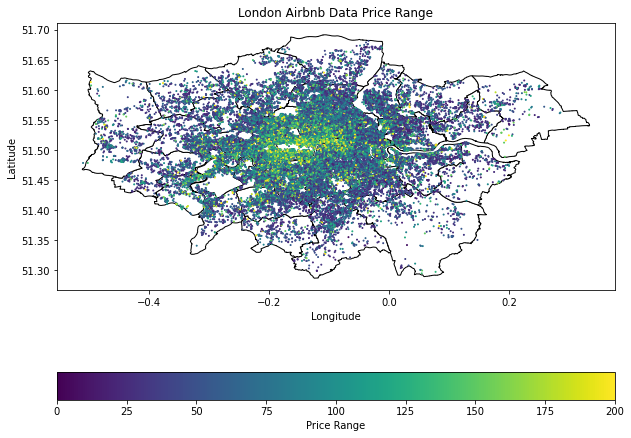

In [ ]:
geojs = gp.read_file('/content/drive/MyDrive/Colab Notebooks/DS-nanodegree/Project 1/data/neighbourhoods.geojson')

df = data
df = df[['latitude','longitude','price']]

df['coords'] = list(zip(df.longitude, df.latitude))
df['coords'] = df['coords'].apply(Point)
df['price'] = np.exp(df['price'])
df = df[df['price']<=200]


gdf = gp.GeoDataFrame(df, geometry='coords')

base = geojs.plot(color='white', edgecolor='black', linewidth = 1, figsize=(10,10))

gdf.plot(ax=base, 
         marker='o', 
         column='price', 
         markersize=1, 
         legend=True,
         legend_kwds={'label': "Price Range", 'orientation': "horizontal"})

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('London Airbnb Data Price Range')

# plt.savefig('/content/drive/MyDrive/Colab Notebooks/DS-nanodegree/Project 1/data/clean_data/Price_map.png', bbox_inches='tight')

### 2. How do different models predict the house price?

The result in this table is not impressive. Look how messy the Linear Regression's R2 score is. The remaining models are even worse. It is overfitting. We can raise hypotheses that the data cleaning step is not good enough. Or maybe the data is not shuffled during the training step. But one thing we can conclude is that the result will be disappointed if we follow traditional methods.

### 3. How to improve the prediction result?

What algorithm comes to your mind when we want to cluster the data? What algorithm do many people suggest when working with tabular data? How can we make sure the result is reliable?

**The answer is: k-means clustering. Gradient Boosting. K-fold cross-validation.**

In conclusion, we have gone through three questions we will concern about when working with the housing dataset. And here is the remark:

- The closer to the city center, the higher the listing price.
- If we do not pay a lot of attention to the preprocessing step, the training data will be messy, and the accuracy of the prediction model will not be good.
- Ensemble models like Gradient Boosting with k-means clustering give a surprisingly good result despite the dirty of the dataset.